In [1]:
# import required packages
from fastai.tabular import *

In [2]:
# path to project directory
path = Path('/home/jupyter/fpl-prediction')

In [3]:
# read in training dataset
# created using fpl_data_clean notebook
train_df = pd.read_csv(path/'data/train_v3.csv', index_col=0, dtype={'season':str})

In [4]:
train_df.tail()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba
87786,Tommy_Doyle,34,3,15,Manchester City,Newcastle United,2.615089,0.598757,True,1,...,0,5,7.0,8,15,7,0,2020-07-08T17:00:00Z,1920,1.0
87787,Joseph_Anang,34,1,0,West Ham United,Burnley,0.711625,0.357798,True,0,...,1,0,0.0,-36,120,156,0,2020-07-08T17:00:00Z,1920,1.0
87788,Erik_Pieters,34,2,90,Burnley,West Ham United,0.357798,0.711625,False,6,...,1,0,4.0,5093,7444,2351,0,2020-07-08T17:00:00Z,1920,1.0
87789,Japhet_Tanganga,34,2,0,Tottenham Hotspur,Bournemouth,1.729412,0.608452,False,0,...,0,0,0.0,-5397,101,5498,0,2020-07-09T17:00:00Z,1920,0.0
87790,Ravel_Morrison,34,3,0,Sheffield United,Wolverhampton Wanderers,0.296788,0.730251,True,0,...,0,1,0.0,-26,2,28,0,2020-07-08T17:00:00Z,1920,0.0


In [5]:
# exclude zero minute rows
#train_df = train_df[train_df['minutes'] != 0].reset_index()

In [6]:
train_df.shape

(87791, 35)

In [7]:
# find the latest gameweek
last_gw = train_df['gw'][train_df['season'] == '1920'].max()

if np.isnan(last_gw): 
    next_gw = 1 
else: 
    next_gw = last_gw + 1
    
next_gw

35

In [8]:
# find validation cut point - index for 18-19 season second half (gw 19)
#valid_start = train_df[(train_df['gw'] > 18) & (train_df['season'] == '1819')].index.min()
# or take validation as same as current prediction set
valid_start = train_df[(train_df['season'] == '1819') & (train_df['gw'] == next_gw)].index.min()
valid_end = train_df[(train_df['season'] == '1920') & (train_df['gw'] == 1)].index.min()
#valid_end = train_df.index.max()

In [9]:
# check data types
train_df.dtypes

player                                  object
gw                                       int64
position                                 int64
minutes                                  int64
team                                    object
opponent_team                           object
relative_market_value_team             float64
relative_market_value_opponent_team    float64
was_home                                  bool
total_points                             int64
assists                                  int64
bonus                                    int64
bps                                      int64
clean_sheets                             int64
creativity                             float64
goals_conceded                           int64
goals_scored                             int64
ict_index                              float64
influence                              float64
own_goals                                int64
penalties_missed                         int64
penalties_sav

In [10]:
# set categorical and continuous variables for tabular learner
cat_vars = ['player', 'gw', 'position', 'team', 'opponent_team', 'was_home', 'season']
cont_vars = ['minutes', 'relative_market_value_team', 'relative_market_value_opponent_team']#, 'ppg_total', 'points_last_5']

In [11]:
# set dependent variable
dep_var = 'total_points'

In [12]:
# set validation dataset based on indexes calculated earlier
valid_idx = range(valid_start, valid_end)

In [13]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]

In [14]:
# create databunch
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .databunch())

In [15]:
# set range of predictions - minimum to current max
max_y = np.max(train_df['total_points'])
min_y = np.min(train_df['total_points'])
y_range = torch.tensor([-1, max_y], device=defaults.device)

In [16]:
# instatiate tabular learner
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [17]:
# take a look at the nueral net architecture
# note that categorical variables all have embeddings (used default embedding sizes)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1293, 88)
    (1): Embedding(39, 12)
    (2): Embedding(5, 4)
    (3): Embedding(30, 11)
    (4): Embedding(30, 11)
    (5): Embedding(3, 3)
    (6): Embedding(5, 4)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=136, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [ ]:
learn.lr_find()

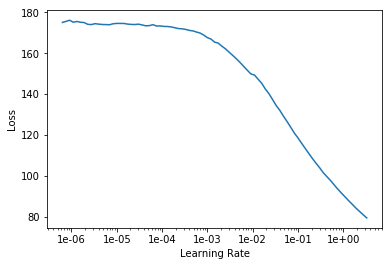

In [166]:
learn.recorder.plot()

In [ ]:
# no market value, latest half season validation
# learn.fit_one_cycle(3, 1.1e-2, wd=0.2)

In [43]:
# market value, latest half season validation
# learn.fit_one_cycle(3, 1.5e-3, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,10.148968,8.108212,2.815272,00:02
1,7.744442,7.921211,2.780680,00:02
2,6.750823,7.586754,2.719187,00:02


In [22]:
# no market value, new season validation
# learn.fit_one_cycle(4, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,8.286838,8.456475,2.861300,00:02
1,7.342739,7.591846,2.721933,00:02
2,7.386149,7.513053,2.702131,00:02
3,6.645412,7.562900,2.718028,00:02


In [18]:
# CURRENT APPROACH
# market value, new season validation
learn.fit_one_cycle(2, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,3.700085,3.507911,1.829350,00:16
1,3.209895,3.329063,1.779507,00:08


In [19]:
# second training run with lower LR
learn.fit_one_cycle(1, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,3.307201,3.351584,1.787614,00:08


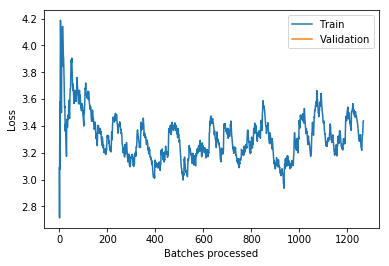

In [19]:
learn.recorder.plot_losses()

In [20]:
# add predictions to the validations set
df_valid = train_df.loc[valid_idx]
df_valid['predicted_points'] = learn.get_preds()[0].data.numpy().T[0]

In [21]:
# look at one team/gameweek
df_valid[(df_valid['team'] == 'Cardiff City') & (df_valid['opponent_team'] == 'Chelsea')].head(10)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba,predicted_points


In [22]:
# look at top predictions
df_valid.sort_values('predicted_points', ascending=False).head(20)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba,predicted_points
66509,Mohamed_Salah,36,3,90,Liverpool,Huddersfield Town,2.177887,0.273778,True,19,...,5,97.0,71136,83818,12682,0,2019-04-26T19:00:00Z,1819,NaN,10.548140
65818,Mohamed_Salah,35,3,90,Liverpool,Cardiff City,2.177887,0.183890,False,6,...,0,55.0,-23964,33993,57957,0,2019-04-21T15:00:00Z,1819,NaN,9.383255
66875,Eden_Hazard,37,3,90,Chelsea,Watford,2.540586,0.412301,True,11,...,3,62.0,31623,64057,32434,0,2019-05-05T13:00:00Z,1819,NaN,8.865461
66596,Sadio_Mané,36,3,90,Liverpool,Huddersfield Town,2.177887,0.273778,True,13,...,5,49.0,168266,187216,18950,0,2019-04-26T19:00:00Z,1819,NaN,8.381432
67748,Mohamed_Salah,38,3,90,Liverpool,Wolverhampton Wanderers,2.177887,0.388177,True,3,...,2,63.0,-123436,35332,158768,0,2019-05-12T14:00:00Z,1819,NaN,8.360968
65470,Eden_Hazard,35,3,90,Chelsea,Burnley,2.540586,0.449442,True,7,...,2,49.0,-249962,22030,271992,0,2019-04-22T19:00:00Z,1819,NaN,7.720949
67856,Sergio_Agüero,38,4,90,Manchester City,Brighton and Hove Albion,2.540586,0.417745,False,6,...,1,59.0,93769,112643,18874,0,2019-05-12T14:00:00Z,1819,NaN,7.565027
66657,Trent_Alexander-Arnold,36,2,87,Liverpool,Huddersfield Town,2.177887,0.273778,True,10,...,5,0.0,131164,137713,6549,0,2019-04-26T19:00:00Z,1819,NaN,7.467839
67232,Sergio_Agüero,37,4,86,Manchester City,Leicester City,2.540586,0.796050,True,2,...,1,54.0,68308,84942,16634,0,2019-05-06T19:00:00Z,1819,NaN,7.450936
66122,Andrew_Robertson,36,2,90,Liverpool,Huddersfield Town,2.177887,0.273778,True,14,...,5,6.0,15389,32054,16665,0,2019-04-26T19:00:00Z,1819,NaN,7.311574


In [23]:
np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])

3.312330722808838

In [24]:
prev_pt_mean = np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['total_points'])
prev_pt_mean

3.426

In [25]:
## now we have decided training approach, need to apply to remainder of season
# read in remaining_season.csv
remaining_season_df = pd.read_csv(path/'data/remaining_season.csv', index_col=0)

In [26]:
remaining_season_df.head(50)
#remaining_season_df[remaining_season_df.player == 'Trent_Alexander-Arnold']

,gw,team,opponent_team,player,position,price,play_proba,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes
0,35,Aston Villa,Crystal Palace,Ahmed_El Mohamady,2,4.1,1.00,True,0.528569,0.419154,1920,9.500000
1,35,Aston Villa,Crystal Palace,James_Chester,2,4.2,0.00,True,0.528569,0.419154,1920,0.000000
2,35,Aston Villa,Crystal Palace,Neil_Taylor,2,4.2,1.00,True,0.528569,0.419154,1920,43.166667
3,35,Aston Villa,Crystal Palace,Kortney_Hause,2,4.4,1.00,True,0.528569,0.419154,1920,90.000000
4,35,Aston Villa,Crystal Palace,Jonathan_Kodjia,4,5.4,0.00,True,0.528569,0.419154,1920,0.000000
5,35,Aston Villa,Crystal Palace,Ørjan_Nyland,1,4.3,1.00,True,0.528569,0.419154,1920,60.000000
6,35,Aston Villa,Crystal Palace,Conor_Hourihane,3,5.7,1.00,True,0.528569,0.419154,1920,45.000000
7,35,Aston Villa,Crystal Palace,Jack_Grealish,3,6.0,1.00,True,0.528569,0.419154,1920,90.000000
8,35,Aston Villa,Crystal Palace,Anwar_El Ghazi,3,5.3,1.00,True,0.528569,0.419154,1920,57.333333
9,35,Aston Villa,Crystal Palace,John_McGinn,3,5.3,1.00,True,0.528569,0.419154,1920,69.166667


In [27]:
# create new databunch, with remaining season as test set
# and using all available data i.e. no validation
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_none()
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .add_test(TabularList.from_df(remaining_season_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [27]:
# instatiate new tabular learner
# learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
#                         y_range=y_range, metrics=rmse)

In [28]:
# train as before
# learn.fit_one_cycle(2, 1e-2, wd=0.2)

In [29]:
# learn.fit_one_cycle(1, 1e-3, wd=0.2)

In [30]:
# get predictions
# test_preds=learn.get_preds(DatasetType.Test)
# remaining_season_df['predicted_points'] = test_preds[0].data.numpy().T[0]

In [31]:
# check mean of top predictions to see if it's reasonably close to previous season's actuals
# re-run if not - not ideal but at the moment the training often over-predicts top players
# pred_pt_mean = np.mean(remaining_season_df.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])
# pred_pt_mean

In [29]:
while True:
    # instatiate new tabular learner
    learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                            y_range=y_range, metrics=rmse)
    
    # train as before
    learn.fit_one_cycle(2, 1e-2, wd=0.2)
    learn.fit_one_cycle(1, 1e-3, wd=0.2)

    # get predictions
    test_preds=learn.get_preds(DatasetType.Test)
    remaining_season_df['predicted_points'] = test_preds[0].data.numpy().T[0]
    
    # check mean of top predictions to see if it's reasonably close to previous season's actuals
    # re-run if not - not ideal but at the moment the training often over-predicts top players
    pred_pt_mean = np.mean(remaining_season_df.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])
    
    if abs((prev_pt_mean - pred_pt_mean) / prev_pt_mean) < 0.15:
        print("Mean of top 1000 predictions: {:.4}".format(pred_pt_mean))
        break
    else:
        print("{:.4}...retraining...".format(pred_pt_mean))

Mean of top 1000 predictions: 2.941


In [30]:
remaining_season_df.shape

(2612, 13)

In [31]:
# quick look
remaining_season_df.sort_values(by='predicted_points', ascending=False).head(20)

,gw,team,opponent_team,player,position,price,play_proba,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes,predicted_points
106,35,Liverpool,Burnley,Mohamed_Salah,3,12.5,1.0,True,2.432402,0.357798,1920,72.0,8.545237
2528,38,Liverpool,Newcastle United,Mohamed_Salah,3,12.5,1.0,False,2.432402,0.598757,1920,72.0,7.276930
1179,38,Manchester City,Norwich,Riyad_Mahrez,3,8.6,1.0,True,2.615089,0.332881,1920,63.0,7.073575
759,37,Liverpool,Chelsea,Mohamed_Salah,3,12.5,1.0,True,2.432402,2.047664,1920,72.0,7.070028
1177,38,Manchester City,Norwich,Kevin_De Bruyne,3,10.8,1.0,True,2.615089,0.332881,1920,66.5,6.969284
985,38,Arsenal,Watford,Pierre-Emerick_Aubameyang,4,10.9,1.0,True,1.484803,0.476464,1920,88.5,6.810270
107,35,Liverpool,Burnley,Sadio_Mané,3,12.3,1.0,True,2.432402,0.357798,1920,75.2,6.677819
1176,38,Manchester City,Norwich,Raheem_Sterling,3,11.7,1.0,True,2.615089,0.332881,1920,57.5,6.594696
97,35,Liverpool,Burnley,Trent_Alexander-Arnold,2,7.8,1.0,True,2.432402,0.357798,1920,83.6,6.469692
1647,36,Liverpool,Arsenal,Mohamed_Salah,3,12.5,1.0,False,2.432402,1.484803,1920,72.0,6.378699


In [32]:
# rename previous week's predictions file
# generate previous week's filename
last_gw = next_gw - 1
filename = 'predictions_gw' + str(last_gw) + '.csv'
! mv predictions.csv $filename

In [33]:
# write to predictions.csv
## RENAME PREVIOUS WEEK FIRST
predictions = remaining_season_df[['gw', 'player', 'team', 'position', 'price', 'play_proba', 'predicted_points']]
predictions.to_csv('predictions.csv')